# 家賃算出モデル  

トレーニングデータは以下から引用  
[「千葉商科大学 商経学部 情報コース 応用情報処理」](https://www3.cuc.ac.jp/~nagaoka/2011/ouyou/11/rent/index.html)  

- なお説明変数(X)のうち、「家の向き」は独自に数値化してみた  

初回のみインストール  

In [ ]:
!pip install numpy
!pip install pandas
!pip install japanize-matplotlib
!pip install scikit-learn


---

Python動作環境  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.colors
import matplotlib.animation
from IPython.display import HTML
import japanize_matplotlib
from sklearn import linear_model


---

## トレーニングデータ：csvファイル読込  

In [2]:
inFileName = 'rent.csv'

data = pd.read_csv(inFileName, sep = ',')
display(data.head(10))

,number,location,monthly_price,house_area,house_age,walk_from_station,direction_of_house,direction_jp
0,1,市川市真間,60000,23.2,19,7,3.0,南
1,2,市川市新田,77000,23.2,16,2,2.7,南東
2,3,市川市真間,60000,32.1,19,10,3.0,南
3,4,市川市新田,62000,18.0,14,11,2.7,南東
4,5,市川市市川南,64000,21.1,0,2,2.3,東
5,6,市川市菅野,51000,15.8,21,12,3.0,南
6,7,市川市菅野,43000,14.6,16,12,3.0,南
7,8,市川市真間,59000,17.4,18,6,2.5,南西
8,9,市川市新田,55000,19.8,16,10,3.0,南
9,10,市川市新田,51000,17.0,18,6,3.0,南


- データの情報  

In [3]:
data.dtypes

number                  int64
location               object
monthly_price           int64
house_area            float64
house_age               int64
walk_from_station       int64
direction_of_house    float64
direction_jp           object
dtype: object

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number              297 non-null    int64  
 1   location            297 non-null    object 
 2   monthly_price       297 non-null    int64  
 3   house_area          297 non-null    float64
 4   house_age           297 non-null    int64  
 5   walk_from_station   297 non-null    int64  
 6   direction_of_house  297 non-null    float64
 7   direction_jp        297 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 18.7+ KB


In [5]:
data.describe()

,number,monthly_price,house_area,house_age,walk_from_station,direction_of_house
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,149.000000,59769.360269,20.820202,16.471380,8.154882,2.719529
std,85.880731,8985.245259,4.014214,8.852013,4.034846,0.397317
min,1.000000,25000.000000,10.000000,0.000000,1.000000,1.000000
25%,75.000000,55000.000000,18.000000,14.000000,5.000000,2.500000
50%,149.000000,60000.000000,20.100000,17.000000,8.000000,3.000000
75%,223.000000,66000.000000,23.100000,20.000000,11.000000,3.000000
max,297.000000,86000.000000,33.000000,43.000000,15.000000,3.000000



---

## 各データと家賃の関係性をチェック  

- 部屋の面積 ＆ 家賃  

In [6]:
W = np.polyfit(data['house_area'], data['monthly_price'], 1)
y_hat = np.polyval(W, data['house_area'])
W

array([ 1213.63210198, 34501.29472795])

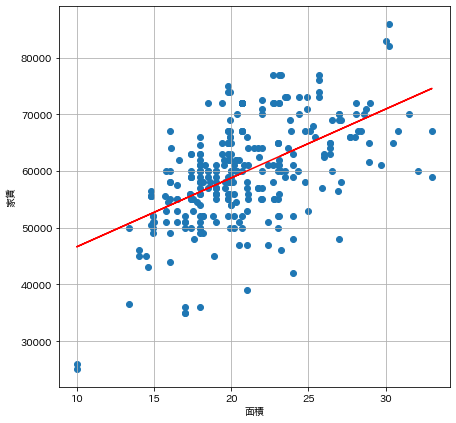

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(data['house_area'], data['monthly_price'])
plt.plot(data['house_area'], y_hat, 'r')
plt.xlabel('面積')
plt.ylabel('家賃')
plt.grid()

- 築年数 ＆ 家賃  

In [8]:
W = np.polyfit(data['house_age'], data['monthly_price'], 1)
y_hat = np.polyval(W, data['house_age'])
W

array([ -613.50807564, 69874.68520545])

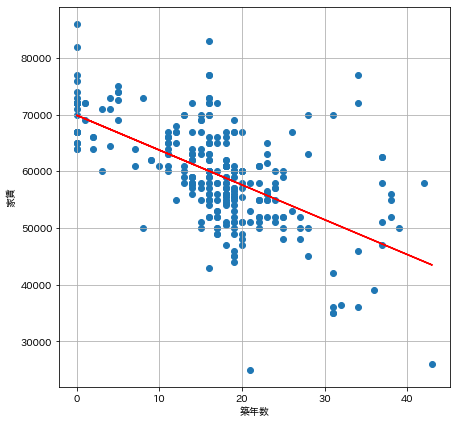

In [9]:
plt.figure(figsize=(7,7))
plt.scatter(data['house_age'], data['monthly_price'])
plt.plot(data['house_age'], y_hat, 'r')
plt.xlabel('築年数')
plt.ylabel('家賃')
plt.grid()

- 駅まで歩いて何分 ＆ 家賃  

In [10]:
W = np.polyfit(data['walk_from_station'], data['monthly_price'], 1)
y_hat = np.polyval(W, data['walk_from_station'])
W

array([ -788.95805356, 66203.22022127])

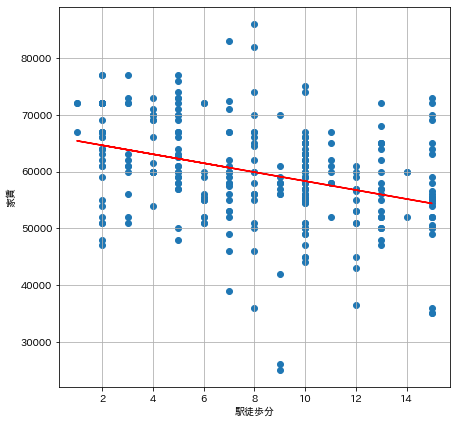

In [11]:
plt.figure(figsize=(7,7))
plt.scatter(data['walk_from_station'], data['monthly_price'])
plt.plot(data['walk_from_station'], y_hat, 'r')
plt.xlabel('駅徒歩分')
plt.ylabel('家賃')
plt.grid()

- 家の向き(南：3.0 ～ 北：1.0) ＆ 家賃  

In [12]:
W = np.polyfit(data['direction_of_house'], data['monthly_price'], 1)
y_hat = np.polyval(W, data['direction_of_house'])
W

array([  848.28762978, 57462.41778259])

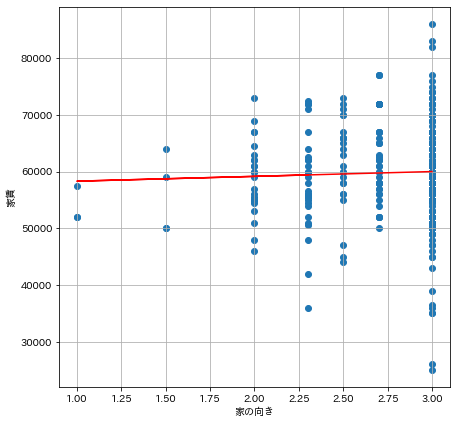

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(data['direction_of_house'], data['monthly_price'])
plt.plot(data['direction_of_house'], y_hat, 'r')
plt.xlabel('家の向き')
plt.ylabel('家賃')
plt.grid()


---

## 家賃算出モデルを作成  

- 目的変数(y)：算出結果 → 家賃  
- 説明変数(X)：算出に影響を与える項目 → 面積・築年数・駅徒歩分・家の向き  


In [14]:
y = data['monthly_price']
X = data[['house_area', 'house_age', 'walk_from_station', 'direction_of_house']]

reg = linear_model.LinearRegression()
X = X.values
reg.fit(X, y)

LinearRegression()

家賃を算出する式  
`y = b0 + (b1 * x1) + (b2 * x2) + (b3 * x3) + (b4 * x4)` の bを表示  
以下の順番で出力される  
- b1：面積の係数  
- b2：築年数の係数  
- b3：駅徒歩分の係数  
- b4：家の向きの係数  

In [15]:
print(reg.coef_)

[1033.03350706 -534.29657955 -460.25957578 1270.300408  ]


- b0：切片を算出  

In [16]:
reg.intercept_

47360.74049115615

決定係数：1に近いほど、モデルの精度が高い  

In [17]:
reg.score(X, y)

0.6437087456963198


---

## 予測：家賃を算出してみる  

- x1：面積 (小数点1桁まで入力)  
- x2：築年数 (0～)  
- x3：駅まで歩いて何分か (0～)  
- x4：家の向き (南：3.0、南東：2.7、南西：2.5、東：2.3、西：2.0、北東：1.5、北：1.0)  

In [18]:
x1 = 17.0
x2 = 15
x3 = 20
x4 = 1.0

price = reg.predict([[x1, x2, x3, x4]])
print('¥' +'{:,.0f}'.format(int(price)))

¥48,972


- 北→南向きの部屋に変更  

In [19]:
x1 = 17.0
x2 = 15
x3 = 20
x4 = 3.0    #変更

price = reg.predict([[x1, x2, x3, x4]])
print('¥' +'{:,.0f}'.format(int(price)))

¥51,513


- 徒歩20分 → 10分  

In [20]:
x1 = 17.0
x2 = 15
x3 = 10    #変更
x4 = 3.0

price = reg.predict([[x1, x2, x3, x4]])
print('¥' +'{:,.0f}'.format(int(price)))

¥56,116


- 広い部屋：面積を25㎡へ  

In [21]:
x1 = 25.0    #変更
x2 = 15
x3 = 10
x4 = 3.0

price = reg.predict([[x1, x2, x3, x4]])
print('¥' +'{:,.0f}'.format(int(price)))

¥64,380


- 徒歩10分 → 5分  

In [22]:
x1 = 25.0
x2 = 15
x3 = 5    #変更
x4 = 3.0

price = reg.predict([[x1, x2, x3, x4]])
print('¥' +'{:,.0f}'.format(int(price)))

¥66,681


- 築15年 → 新築(0年)に変更  

In [23]:
x1 = 25.0
x2 = 0    #変更
x3 = 5
x4 = 3.0

price = reg.predict([[x1, x2, x3, x4]])
print('¥' +'{:,.0f}'.format(int(price)))

¥74,696


-  徒歩5分 → 徒歩0分(駅近)に変更  

In [24]:
x1 = 25.0
x2 = 0
x3 = 0    #変更
x4 = 3.0

price = reg.predict([[x1, x2, x3, x4]])
print('¥' +'{:,.0f}'.format(int(price)))

¥76,997



---
